In [1]:
#local imports
from gsom import GSOM 
from npsomfinal import NPSOM  , rank_features_by_variance , rank_features_by_activation , rank_features_by_activation2 , rank_features_by_importance , rank_features_by_hybridapproach
from pca import get_reduced_data
from classifier import get_test_accuracy

In [2]:
#global imports
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import torch


In [87]:
DATAset_name = 'ROSMAP'

In [88]:
# Load training data
data1 = np.loadtxt(f"{DATAset_name}/1_tr.csv", delimiter=",", dtype=np.float64)
data2 = np.loadtxt(f"{DATAset_name}/2_tr.csv", delimiter=",", dtype=np.float64)
data3 = np.loadtxt(f"{DATAset_name}/3_tr.csv", delimiter=",", dtype=np.float64)
data = np.hstack((data1 , data2 , data3))
labels = np.loadtxt(f"{DATAset_name}/labels_tr.csv", delimiter=",", dtype=np.int32)

# Load testing data
X_test1 = np.loadtxt(f"{DATAset_name}/1_te.csv", delimiter=",", dtype=np.float64)
X_test2 = np.loadtxt(f"{DATAset_name}/2_te.csv", delimiter=",", dtype=np.float64)
X_test3 = np.loadtxt(f"{DATAset_name}/3_te.csv", delimiter=",", dtype=np.float64)
X_test = np.hstack((X_test1 , X_test2 , X_test3))
y_test = np.loadtxt(f"{DATAset_name}/labels_te.csv", delimiter=",", dtype=np.int32)

print("Training Data Shape:", data.shape)  
print("Test Data Shape:", X_test.shape) 

Training Data Shape: (245, 600)
Test Data Shape: (106, 600)


In [51]:
num_features = 300

In [6]:
plt.ion()

In [52]:
def get_data_npsom(data , X_test , num_features):
    grid_size = (5 , 5)  # 10x10 grid
    input_dim = data.shape[1]
    npsom = NPSOM(grid_size, input_dim,sigma=1,  learning_rate=0.1, decay_rate=1e-5)
    npsom.train(data , num=1 ,  batch_size=10  , iterations_per_batch=5)
    feature_rankings , feature_contributions = rank_features_by_importance(npsom)
    top_features = feature_rankings[:num_features]
    reduced_data1 = data[:, top_features]
    reduced_test1 = X_test[:, top_features]
    return reduced_data1 , reduced_test1    

Processing Batch 1/62
0 neuron deleted at []
neuron added
Processing Batch 2/62
neuron added
Processing Batch 3/62
neuron added
Processing Batch 4/62
neuron added
Processing Batch 5/62
neuron added
Processing Batch 6/62
neuron added
Processing Batch 7/62
neuron added
Processing Batch 8/62
neuron added
Processing Batch 9/62
neuron added
Processing Batch 10/62
neuron added
Processing Batch 11/62
1 neuron deleted at [27]
neuron added
Processing Batch 12/62
neuron added
Processing Batch 13/62
neuron added
Processing Batch 14/62
neuron added
Processing Batch 15/62
neuron added
Processing Batch 16/62
neuron added
Processing Batch 17/62
neuron added
Processing Batch 18/62
neuron added
Processing Batch 19/62
neuron added
Processing Batch 20/62
neuron added
Processing Batch 21/62
1 neuron deleted at [37]
neuron added
Processing Batch 22/62
neuron added
Processing Batch 23/62
neuron added
Processing Batch 24/62
neuron added
Processing Batch 25/62
neuron added
Processing Batch 26/62
neuron added


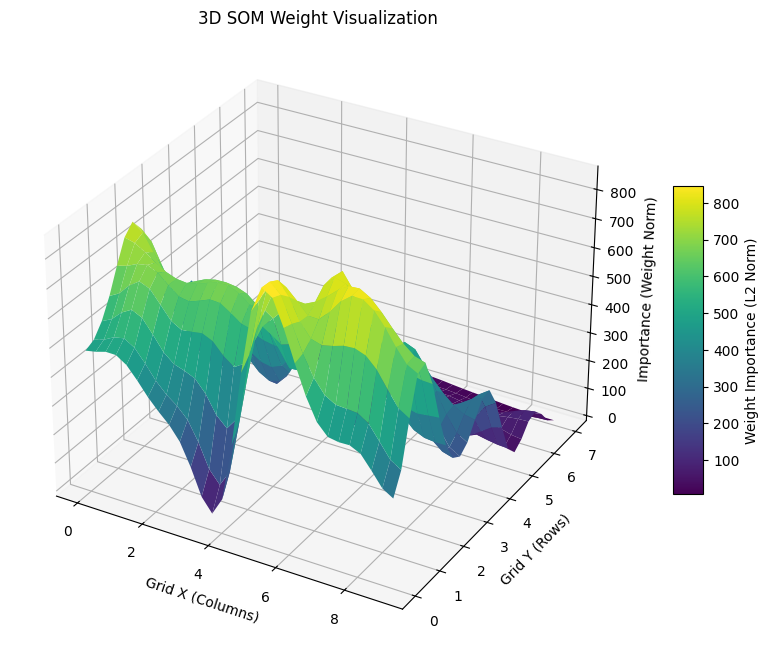

In [53]:
grid_size = (5 , 5)  # 10x10 grid
input_dim = data.shape[1]
npsom = NPSOM(grid_size, input_dim,sigma=1,  learning_rate=0.1, decay_rate=1e-5)
npsom.train(data , num=1 ,  batch_size=10  , iterations_per_batch=5)
npsom.visualize_weights()

#rank_features_by_variance(npsom)
feature_rankings , feature_contributions = rank_features_by_importance(npsom)
top_features = feature_rankings[:num_features]
reduced_data1 = data[:, top_features]
reduced_test1 = X_test[:, top_features]

In [6]:
def get_data_gsom(data , X_test , num_features):
    scaler = StandardScaler()
    data2 = scaler.fit_transform(data)
    gsom = GSOM(input_dim=data.shape[1], spread_factor=0.8, learning_rate=0.1, max_iter=500)
    gsom.train(data2)
    selected_features = gsom.get_feature_reduction(numoffeatures=num_features)  
    reduced_data2 = data[: ,selected_features]
    reduced_test2 = X_test[:, selected_features]
    return reduced_data2 , reduced_test2

In [11]:
scaler = StandardScaler()
data2 = scaler.fit_transform(data)

# Train GSOM
gsom = GSOM(input_dim=data.shape[1], spread_factor=0.8, learning_rate=0.1, max_iter=500)
gsom.train(data2)

# Get reduced feature set
selected_features = gsom.get_feature_reduction(numoffeatures=num_features)
print("Selected Feature Indices:", selected_features)
reduced_data2 = data[: ,selected_features]
reduced_test2 = X_test[:, selected_features]

Selected Feature Indices: [1625 1107 1834  237 1708  624 1391  196 1775   56   82  441 1947 1529
 1964 1712   69   48  997 1283  429    2 1252  721 1452 1904  199 1845
  796 1732  874  705 1873  215 1954  304 2426  952  445 1844 1367  512
    8 1551   46 1485  665  751  300  412 1394  253 1182 1564  433  737
 1837  509  825 2049 1186  969  889  801 1872  714 1820 1595 1308 1275
  686  271 1972  444  903   97 1539  728  972  333 1168 1737  424  395
  592 1645  155  614 1574  749 1783 1843  810 1384  807  489  319 1412
 1827  125]


In [7]:
def get_reduced_data(data , X_test , numoffeatures):

    pca = PCA(n_components=numoffeatures)  # Keep top 100 features
    X_pca = pca.fit_transform(data)
    X_pca2 = pca.transform(X_test)
    explained_variance = np.sum(pca.explained_variance_ratio_) * 100
    #print(f"Total explained variance with {numoffeatures} features: {explained_variance:.2f}%")
    reduced_data = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(numoffeatures)]).values
    reduced_test = pd.DataFrame(X_pca2,  columns=[f'PC{i+1}' for i in range(numoffeatures)]).values
    return reduced_data , reduced_test

In [8]:
reduced_data3 , reduced_test3 = get_reduced_data(data , X_test , 300)

In [15]:
def get_sqindices(labels  , num_classes):
    # Convert labels to range [0, 4] and ensure correct dtype
    y_train = torch.tensor(labels, dtype=torch.long) 
    # Count samples per class
    class_indices = {c: np.where(y_train.numpy() == c)[0] for c in range(num_classes)}

    # Determine equal support set size for all classes
    n_support_per_class = min(len(class_indices[c]) * 3 // 4 for c in range(num_classes))
    n_support_per_class -= n_support_per_class % 2  # Ensure even number
    n_support = n_support_per_class * num_classes  # Total support samples

    support_indices = []
    query_indices = []

    for c in range(num_classes):
        support_samples = np.random.choice(class_indices[c], n_support_per_class, replace=False)
        query_samples = np.setdiff1d(class_indices[c], support_samples)

        support_indices.extend(support_samples)
        query_indices.extend(query_samples)

    return support_indices , query_indices

support_indices , query_indices = get_sqindices(labels  , num_classes=5)
    

def get_test_accuracy(reduced_data , reduced_test , labels , y_test ,support_indices , query_indices ,state_dict , num_classes = 5 , lr=0.05 , num_epoch=1000 , embedding_dim = 50):
    # Model setup

    # Convert labels to range [0, 4] and ensure correct dtype
    y_train = torch.tensor(labels, dtype=torch.long)  
    y_test = torch.tensor(y_test, dtype=torch.long)
    support_set = torch.tensor(reduced_data[support_indices], dtype=torch.float32)
    query_set = torch.tensor(reduced_data[query_indices], dtype=torch.float32)
    support_labels = torch.tensor(y_train[support_indices], dtype=torch.long)
    query_labels = torch.tensor(y_train[query_indices], dtype=torch.long)
    print(query_labels)
    input_dim = support_set.shape[1]  
    embedding_net = EmbeddingNet(input_dim, embedding_dim)
    embedding_net.load_state_dict(state_dict)
    proto_net = PrototypicalNetwork(embedding_net)

    # Training setup
    optimizer = optim.Adagrad(proto_net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Define class count and sample sizes
    n_classes = num_classes
    n_query = len(query_indices)  # Total query samples
    n_support = len(support_indices)

    losses  = []

    # Training loop
    for epoch in range(num_epoch):
        proto_net.train()
    
        logits = proto_net(support_set, query_set, n_classes, n_support, n_query)
        loss = criterion(logits, query_labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    losses = np.array(losses)
    plt.figure(figsize=(10, 5))
    plt.plot(losses)

    # Evaluate on test set
    proto_net.eval()
    X_test_tensor = torch.tensor(reduced_test, dtype=torch.float32)  # Convert NumPy array to tensor
    test_logits = proto_net(support_set, X_test_tensor, n_classes, n_support, X_test_tensor.shape[0])
    test_preds = torch.argmax(test_logits, dim=1)
    accuracy = (test_preds == y_test).float().mean().item()
    return accuracy

embedding_net = EmbeddingNet(reduced_data1.shape[1], embedding_dim = 100)
state_dict = embedding_net.state_dict()
get_test_accuracy(reduced_data1, reduced_test1 , labels , y_test ,support_indices , query_indices ,state_dict , num_classes = 5 , lr=0.05 , num_epoch=1000 , embedding_dim = 100)

NameError: name 'EmbeddingNet' is not defined

In [83]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold

# Compute variances of each feature
variances = np.var(data, axis=0)

# Select indices of top 300 features
top_indices = np.argsort(variances)[-300:]
X_top300 = data[:, top_indices]
X_test300 =X_test[:, top_indices]
X_top300.shape

(612, 300)

In [49]:
reduced_data1.shape

(612, 300)

55.51331043243408

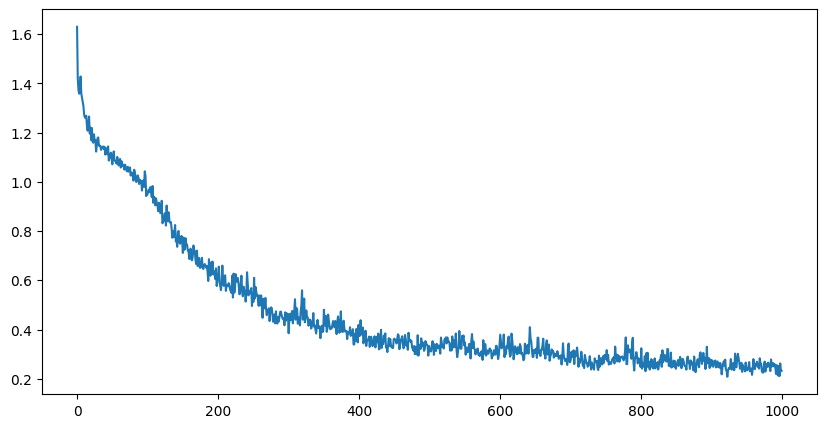

In [86]:
get_test_accuracy(X_top300 , X_test300 , labels , y_test ,num_classes = 5 , lr=0.05 , num_epoch=1000 , l2_lambda = 0.00)*100

In [61]:
import numpy as np
import pandas as pd

# Assume data is a NumPy array (rows = samples, columns = features)
# Step 1: Convert to DataFrame
X_df = pd.DataFrame(data)

# Step 2: Compute absolute correlation matrix
corr_matrix = X_df.corr().abs()

# Step 3: Keep upper triangle to avoid duplicate checks
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 4: Find features with high correlation
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Step 5: Drop highly correlated features
X_filtered = X_df.drop(columns=to_drop)

# Step 6: Select top 300 features based on variance
variances = X_filtered.var()
top_features = variances.sort_values(ascending=False).index[:300]
X_top300 = X_filtered[top_features].values
X_test = X_test[:, top_features]

IndexError: index 1564 is out of bounds for axis 1 with size 300

In [69]:
import numpy as np
from skfeature.function.similarity_based import lap_score, SPEC
from skfeature.function.sparse_learning_based import MCFS, UDFS, NDFS

# Your feature matrix: data (shape: [n_samples, n_features])
# Assuming data and X_test are already defined

# --- 1. Laplacian Score ---
# Calculate weight matrix first (required for lap_score)
kwargs_lapscores = {"metric": "euclidean"}
W = lap_score.construct_W(data, **kwargs_lapscores)
# Lower values are better for Laplacian scores
lap_scores = lap_score.lap_score(data, W=W)
# Since lower is better, we use argsort (not reversed)
top_indices_ls = lap_scores.argsort()[:300]
X_top300_ls = data[:, top_indices_ls]
X_test_ls = X_test[:, top_indices_ls]

# --- 2. SPEC (Spectral Feature Selection) ---
# SPEC uses the same weight matrix as lap_score, so we can reuse it
# W is already created from lap_score section
# For SPEC, lower values are better
spec_scores = SPEC.spec(data, W=W, style=0)  # style=0 is the default
top_indices_spec = spec_scores.argsort()[:300]
X_top300_spec = data[:, top_indices_spec]
X_test_spec = X_test[:, top_indices_spec]

# --- 3. MCFS (Multi-Cluster Feature Selection) ---
# For MCFS, higher values indicate more important features
kwargs_mcfs = {"n_clusters": 10, "n_selected_features": 300}
mcfs_scores = MCFS.mcfs(data, **kwargs_mcfs)
# Get indices of top features (higher is better)
top_indices_mcfs = mcfs_scores.argsort()[:300]
X_top300_mcfs = data[:, top_indices_mcfs]
X_test_mcfs = X_test[:, top_indices_mcfs]

# --- 4. UDFS (Unsupervised Discriminative Feature Selection) ---
# For UDFS, higher values indicate more important features
kwargs_udfs = {"gamma": 0.1, "n_selected_features": 300}
udfs_scores = UDFS.udfs(data, **kwargs_udfs)
# Get indices of top features (higher is better)
top_indices_udfs = udfs_scores.argsort()[:300]
X_top300_udfs = data[:, top_indices_udfs]
X_test_udfs = X_test[:, top_indices_udfs]



In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Generate sample data for demonstration
# In a real scenario, you would load your actual data
np.random.seed(42)
n_samples = 600
n_features = 2500

# Create synthetic data (replace this with your actual data loading)
X = np.random.randn(n_samples, n_features)
# Create binary labels for classification
y = np.random.randint(0, 2, size=n_samples)

# Split the data
X_train, X_test, y_train, y_test = data , X_test , labels , y_test

# Define multiple classification models suitable for high-dimensional data
models = {
    # L1 regularization (Lasso) helps with sparse feature selection
    'log_reg_l1': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=0.01, penalty='l1', solver='liblinear', max_iter=1000))
    ]),
    
    # L2 regularization (Ridge) helps with highly correlated features
    'log_reg_l2': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=0.01, penalty='l2', max_iter=1000))
    ]),
    
    # Linear SVM with L2 regularization
    'linear_svc': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LinearSVC(C=0.01, penalty='l2', dual=False, max_iter=5000))
    ]),
    
    # Random Forest can handle high-dimensional data naturally
    'random_forest': Pipeline([
        ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42))
    ])
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate ROC AUC if possible
    try:
        y_score = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_score)
    except:
        try:
            y_score = model.decision_function(X_test)
            auc = roc_auc_score(y_test, y_score)
        except:
            auc = None
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'auc': auc
    }
    
    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    if auc is not None:
        print(f"ROC AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))

# Find the best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nBest model: {best_model_name}")
print(f"Best accuracy: {results[best_model_name]['accuracy']:.4f}")
if results[best_model_name]['auc'] is not None:
    print(f"Best ROC AUC: {results[best_model_name]['auc']:.4f}")

# Advanced: Cross-validation for the best model
best_model = models[best_model_name]
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy for {best_model_name}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


Model: log_reg_l1
Accuracy: 0.6274
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.94      0.87      0.91        39
           2       0.00      0.00      0.00        14
           3       0.58      1.00      0.73       131
           4       0.00      0.00      0.00        44

    accuracy                           0.63       263
   macro avg       0.30      0.37      0.33       263
weighted avg       0.43      0.63      0.50       263


Model: log_reg_l2
Accuracy: 0.7795
              precision    recall  f1-score   support

           0       0.38      0.29      0.33        35
           1       0.97      0.85      0.90        39
           2       0.71      0.71      0.71        14
           3       0.81      0.92      0.86       131
           4       0.78      0.70      0.74        44

    accuracy                           0.78       263
   macro avg       0.73      0.69      0.71       263
weigh

Processing Batch 1/62
0 neuron deleted at []
neuron added
Processing Batch 2/62
neuron added
Processing Batch 3/62
neuron added
Processing Batch 4/62
neuron added
Processing Batch 5/62
neuron added
Processing Batch 6/62
neuron added
Processing Batch 7/62
neuron added
Processing Batch 8/62
neuron added
Processing Batch 9/62
neuron added
Processing Batch 10/62
neuron added
Processing Batch 11/62
1 neuron deleted at [27]
neuron added
Processing Batch 12/62
neuron added
Processing Batch 13/62
neuron added
Processing Batch 14/62
neuron added
Processing Batch 15/62
neuron added
Processing Batch 16/62
neuron added
Processing Batch 17/62
neuron added
Processing Batch 18/62
neuron added
Processing Batch 19/62
neuron added
Processing Batch 20/62
neuron added
Processing Batch 21/62
1 neuron deleted at [37]
neuron added
Processing Batch 22/62
neuron added
Processing Batch 23/62
neuron added
Processing Batch 24/62
neuron added
Processing Batch 25/62
neuron added
Processing Batch 26/62
neuron added


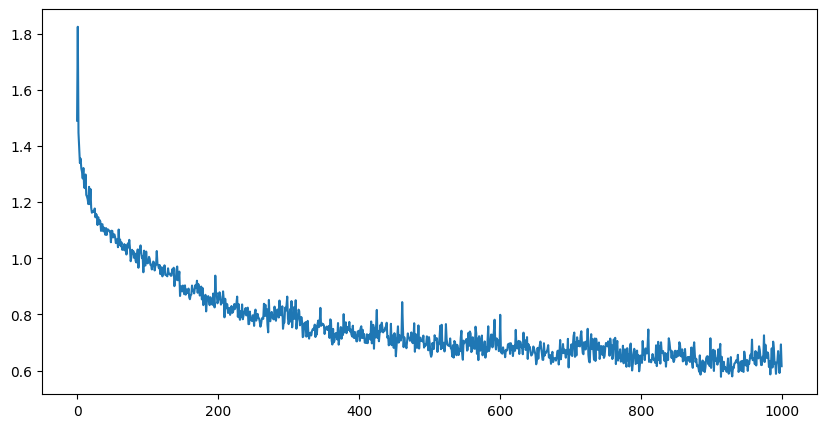

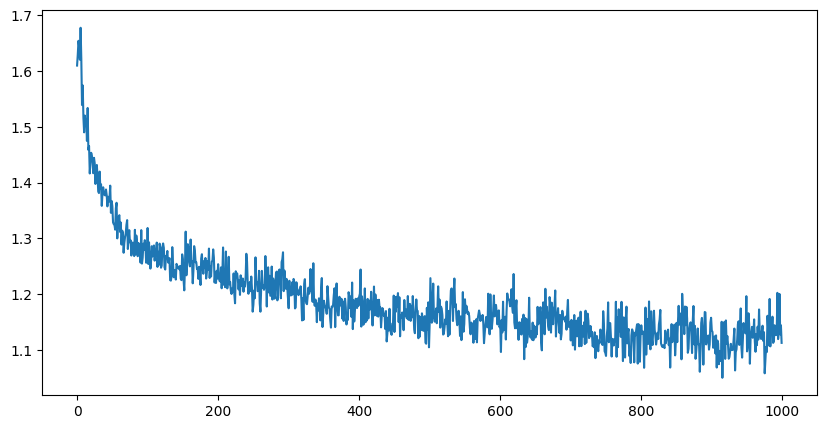

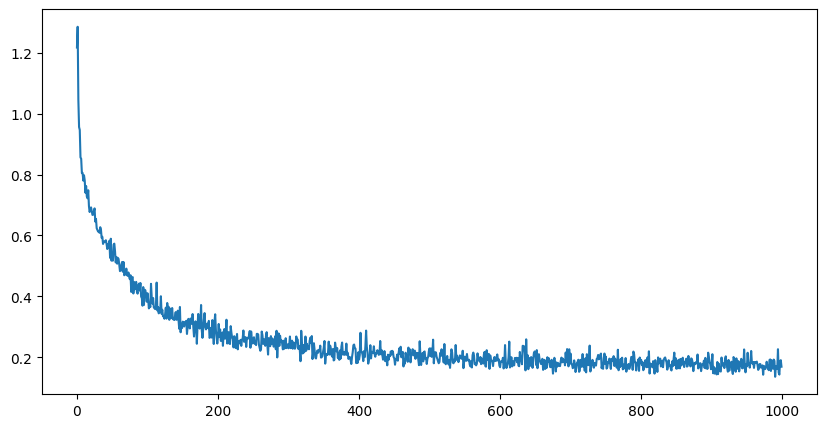

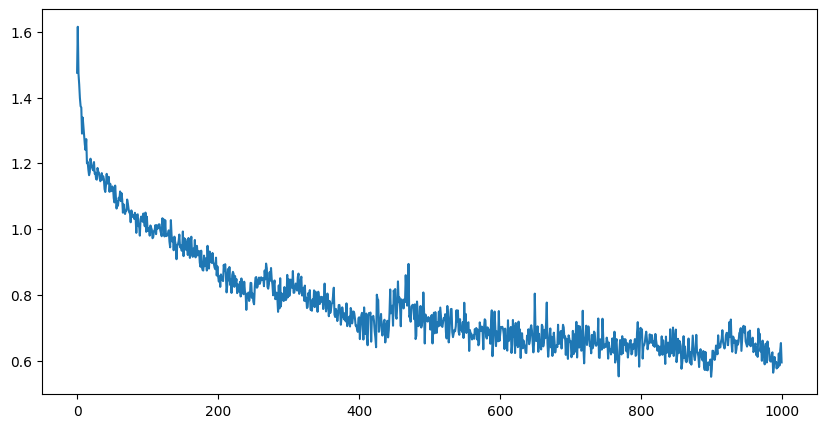

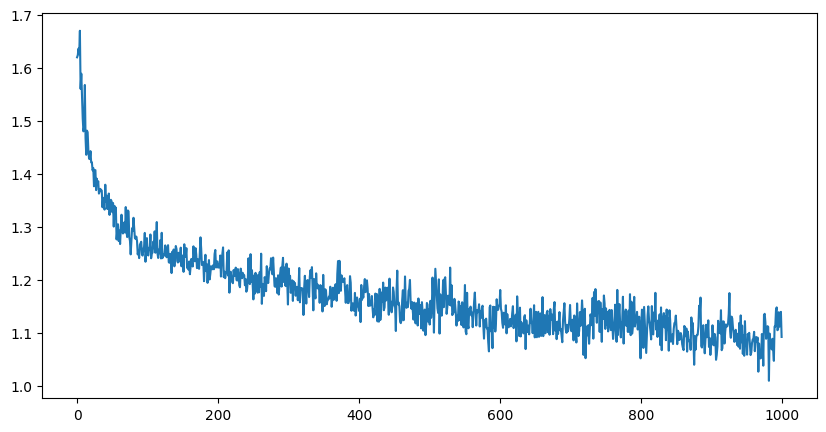

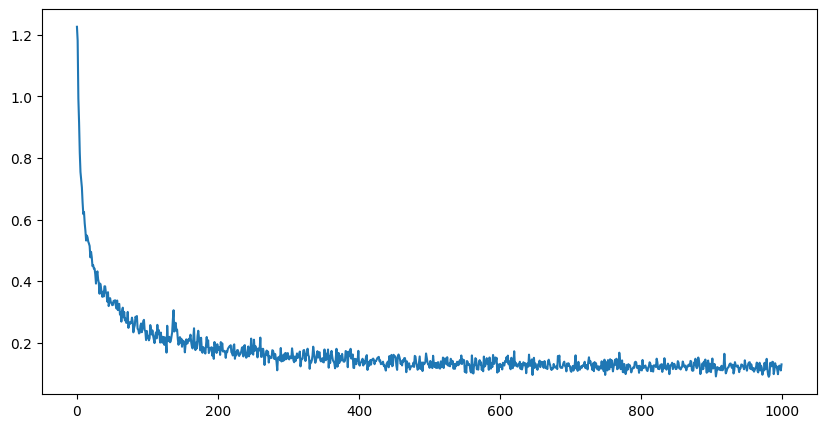

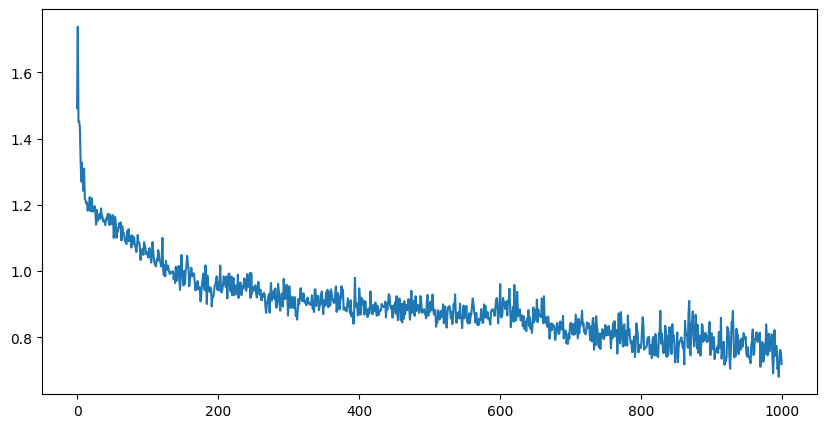

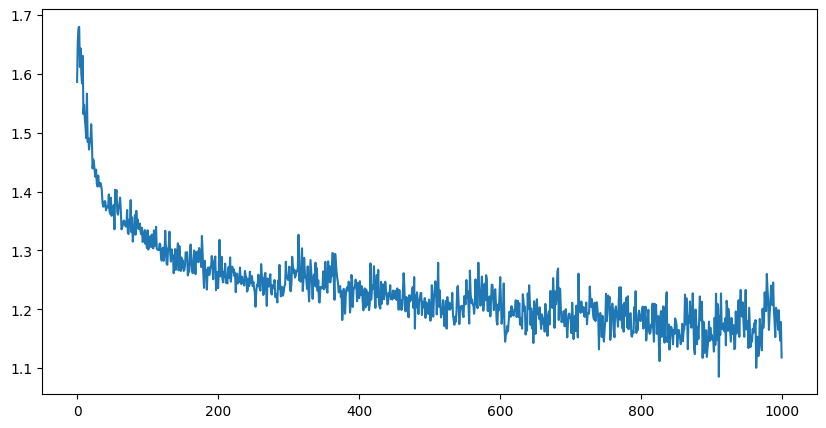

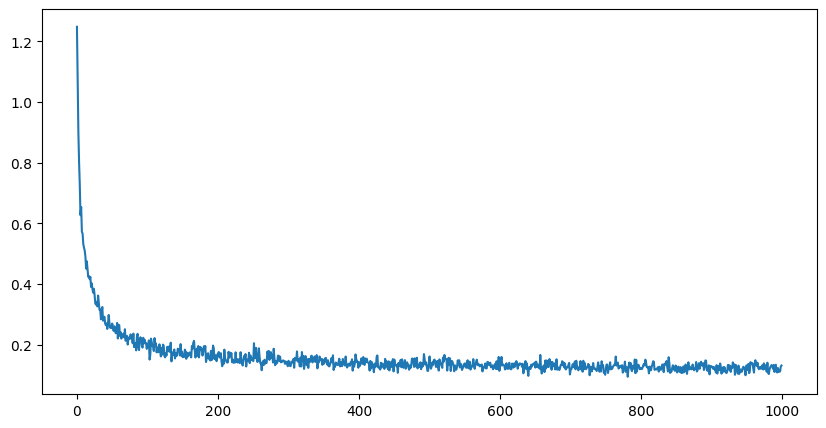

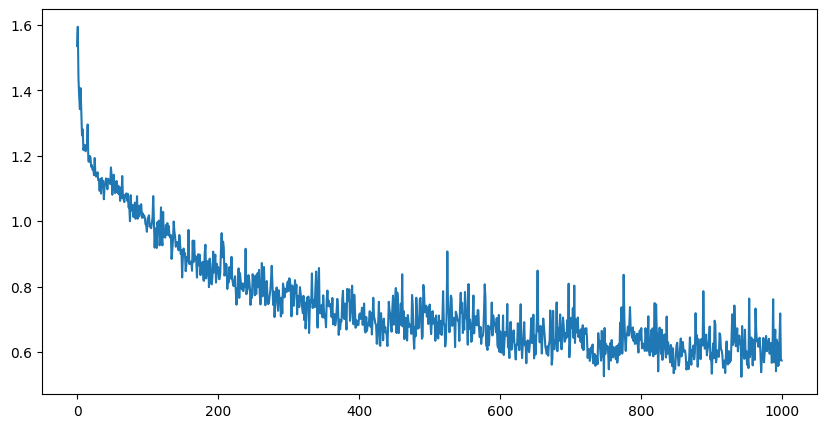

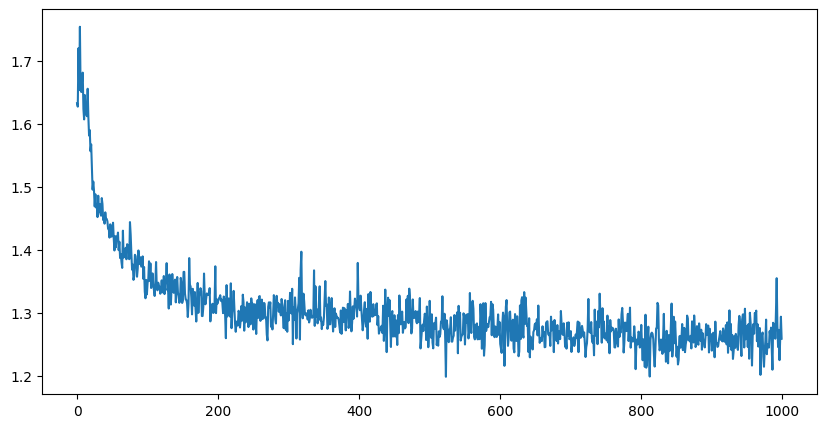

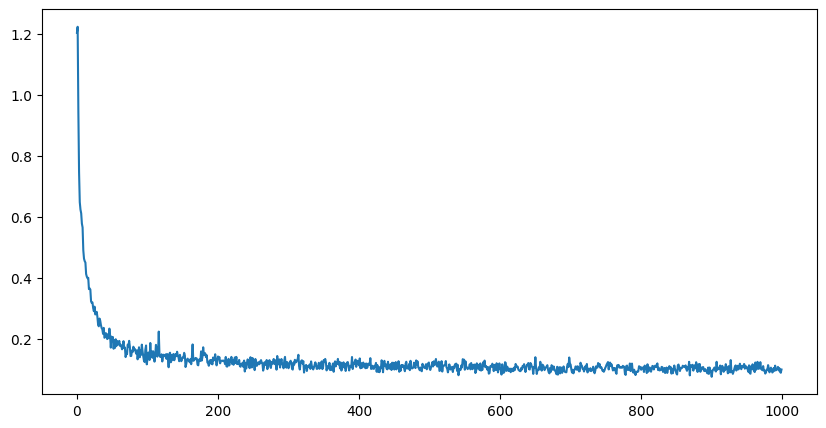

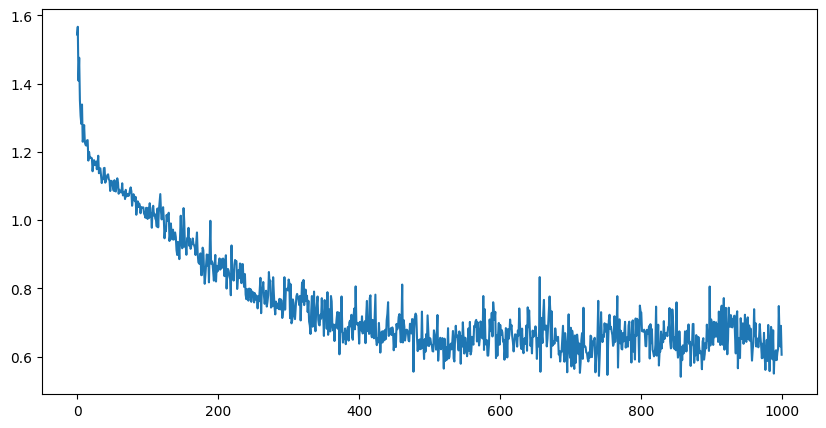

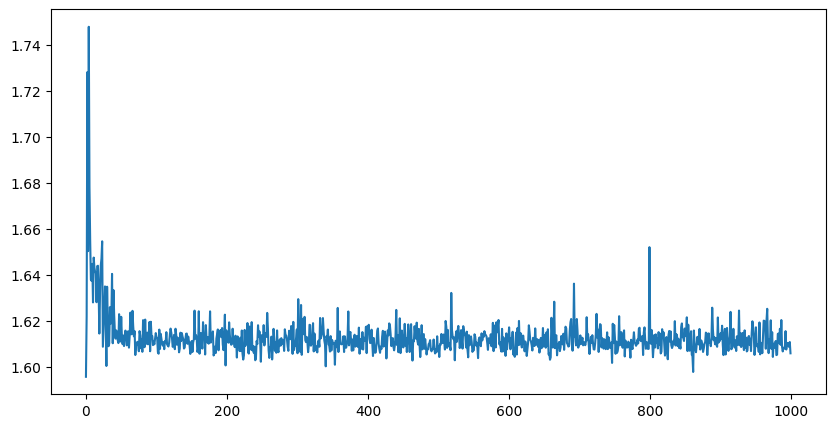

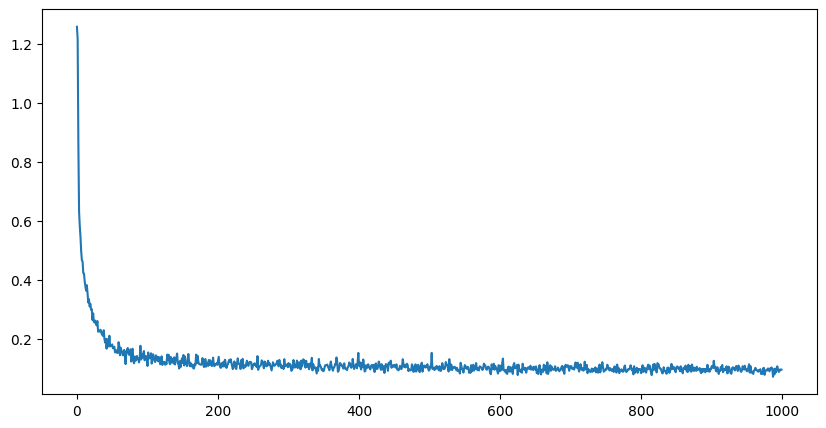

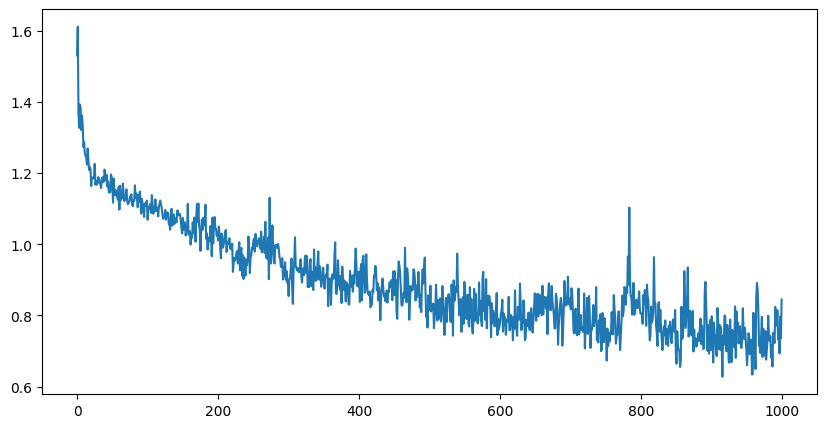

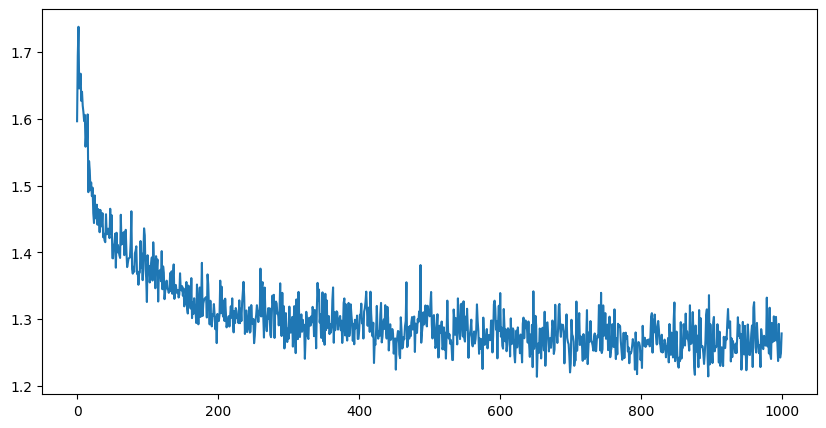

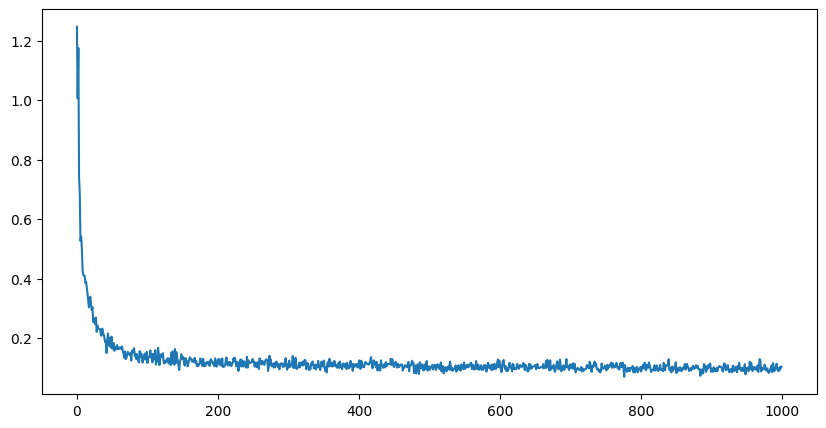

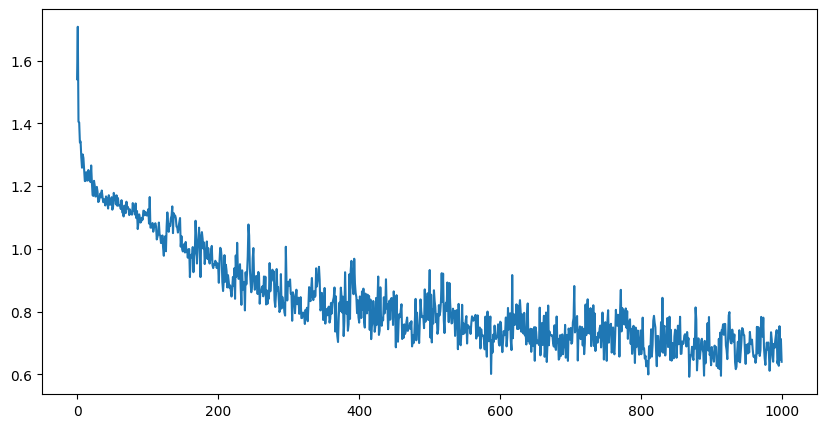

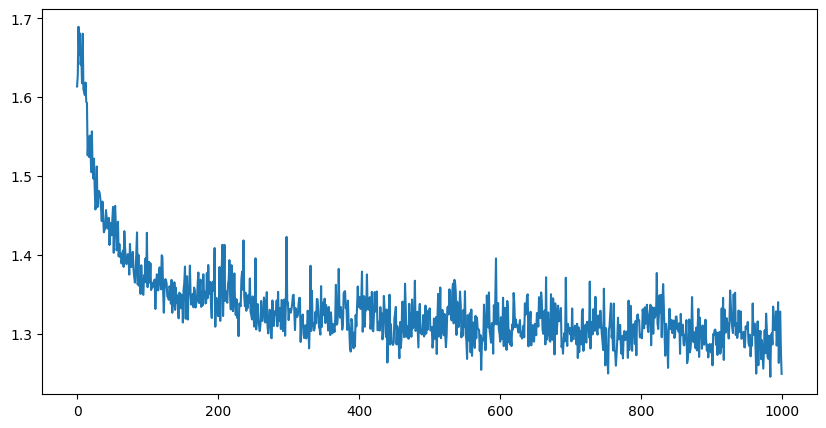

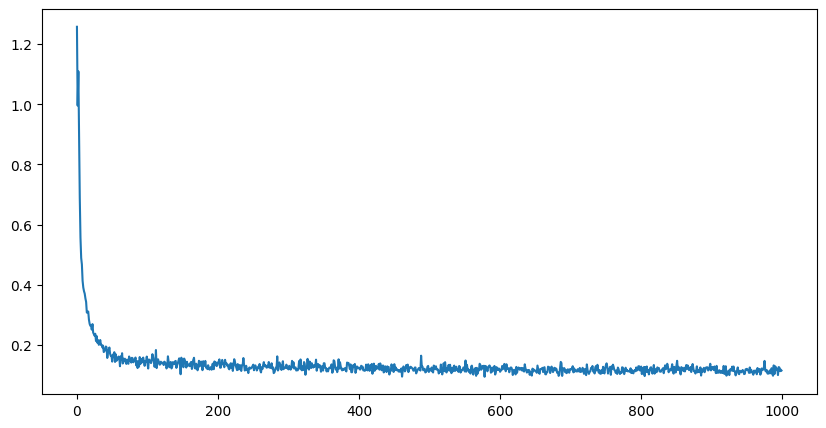

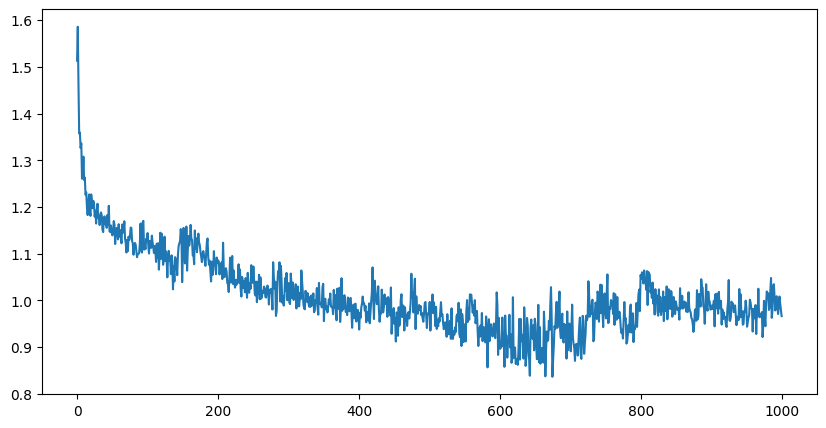

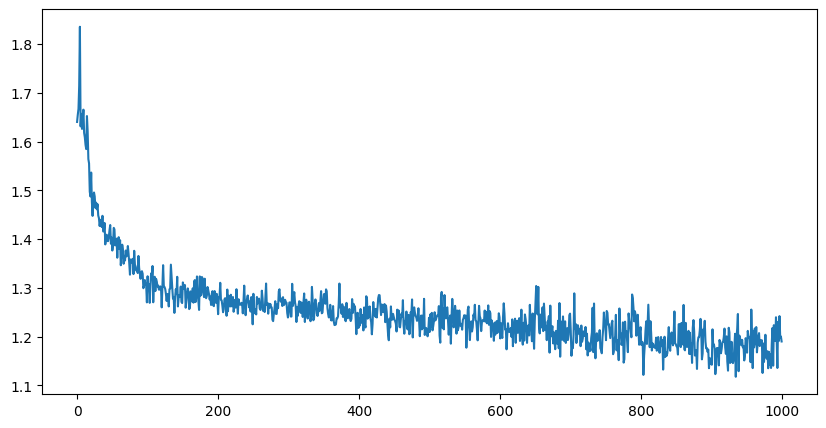

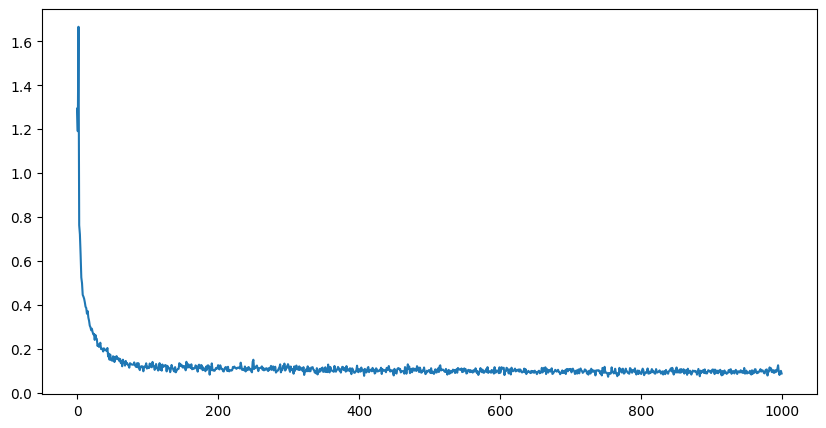

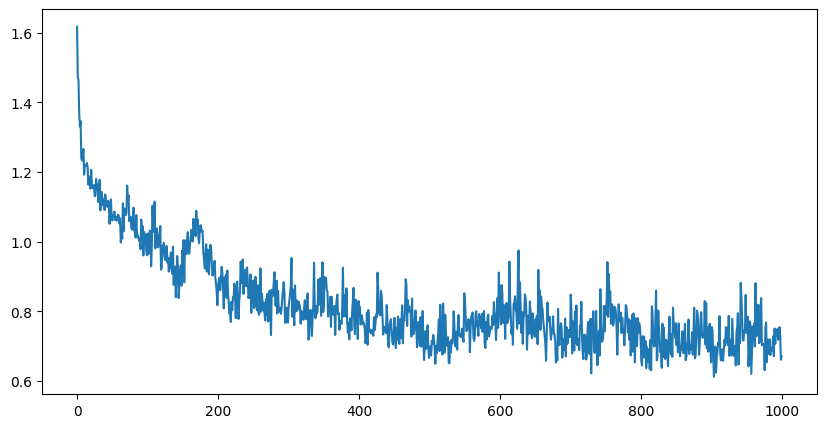

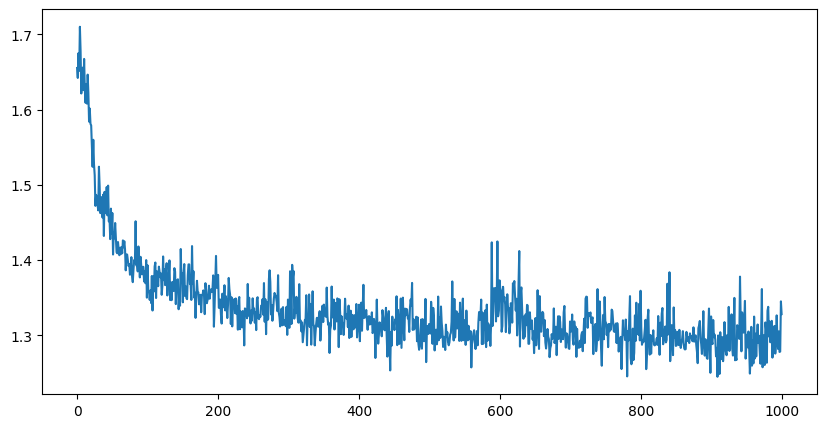

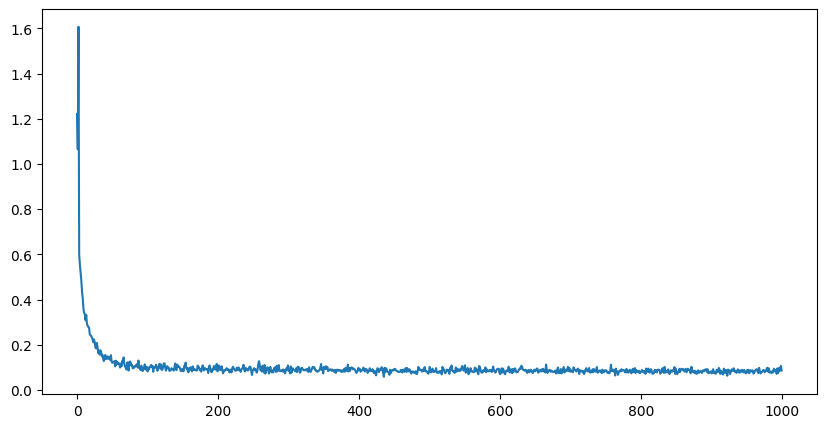

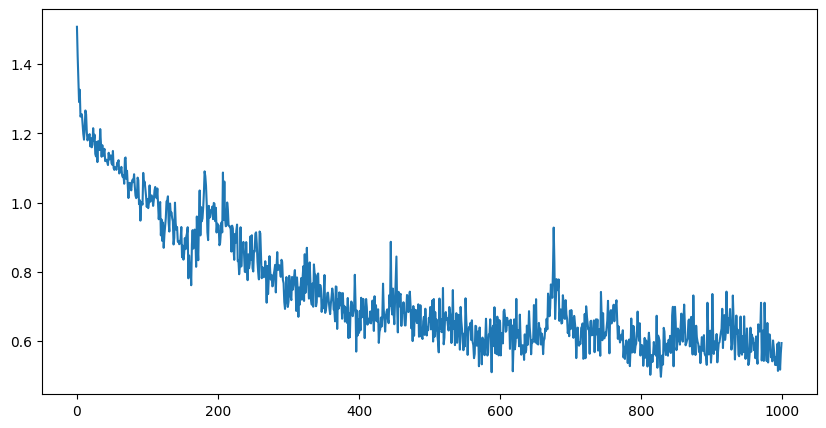

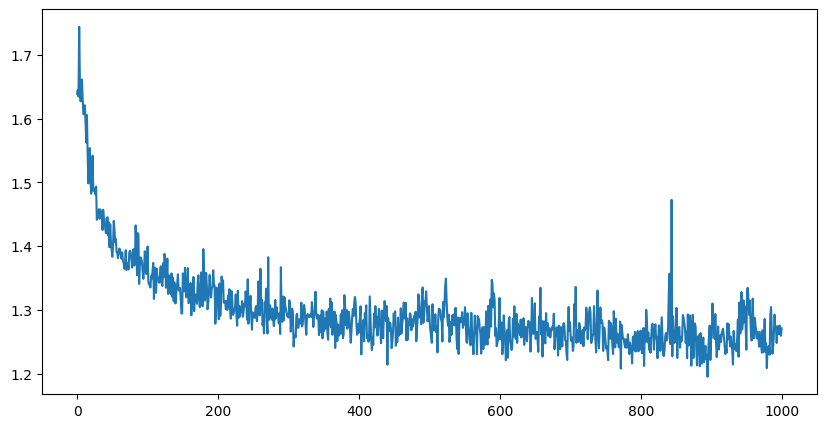

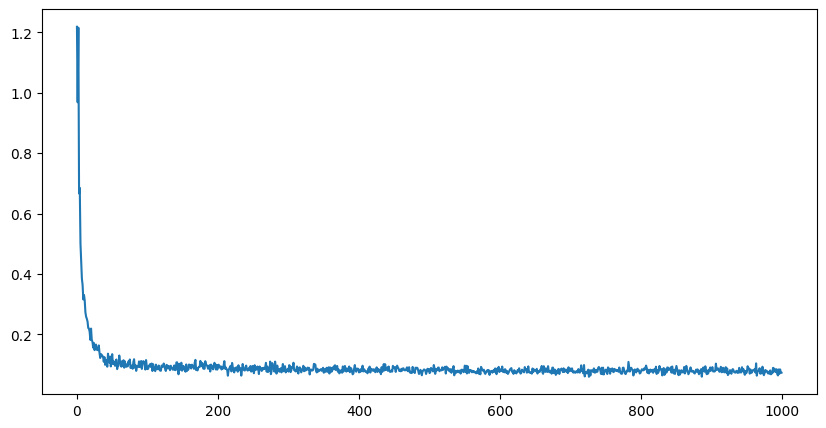

In [38]:
npsom_accuracies = []
gsom_accuracies = []
pca_accuracies = []
lr = 0.05
num_classes = 5
epoch = 1000
l2_lambda = 0.0
numberoffeatures = range(50 ,501 , 50)
for num_feature in numberoffeatures:
    reduced_data, reduced_test = get_data_npsom(data , X_test , num_feature)
    accuracy = get_test_accuracy(reduced_data , reduced_test , labels , y_test ,num_classes = num_classes , lr = lr, num_epoch=epoch , l2_lambda=l2_lambda)*100
    npsom_accuracies.append(accuracy)
    print(f"npsom testing accuracy for {num_feature} {accuracy}%")
    reduced_data, reduced_test = get_data_gsom(data , X_test , num_feature)
    time.sleep(10)
    accuracy = get_test_accuracy(reduced_data , reduced_test , labels , y_test ,num_classes = num_classes , lr=lr , num_epoch=epoch, l2_lambda=l2_lambda)*100
    gsom_accuracies.append(accuracy)
    print(f"gsom testing accuracy for {num_feature} {accuracy}%")
    reduced_data , reduced_test = get_reduced_data(data , X_test , num_feature)
    time.sleep(10)
    accuracy = get_test_accuracy(reduced_data , reduced_test , labels , y_test ,num_classes = num_classes , lr=lr , num_epoch=epoch, l2_lambda=l2_lambda)*100
    print(f"pca testing accuracy for {num_feature} {accuracy}%")
    pca_accuracies.append(accuracy)
    time.sleep(10)

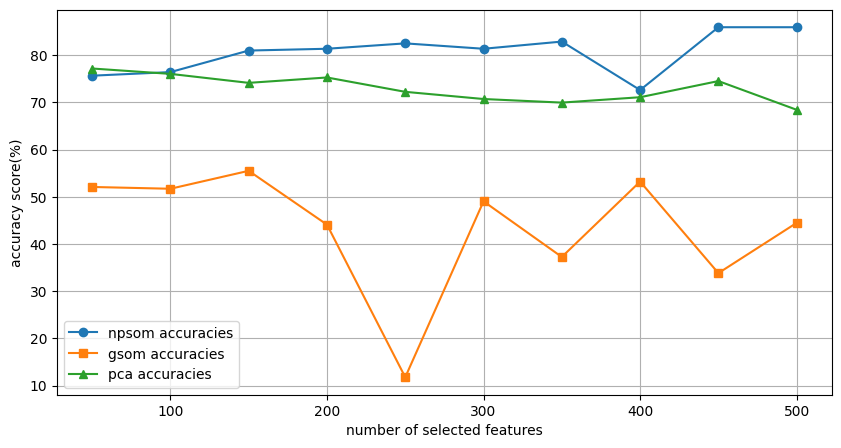

In [40]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(numberoffeatures ,npsom_accuracies, label='npsom accuracies', marker='o')
plt.plot(numberoffeatures ,gsom_accuracies, label='gsom accuracies', marker='s')
plt.plot(numberoffeatures ,pca_accuracies, label='pca accuracies', marker='^')

# Labels and legend
plt.xlabel('number of selected features')
plt.ylabel('accuracy score(%)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [25]:
npsom_accuracies 

[75.28517246246338,
 78.7072241306305,
 80.98859190940857,
 81.74905180931091,
 83.65018963813782,
 84.41064357757568,
 83.26995968818665,
 73.384028673172,
 72.62357473373413]

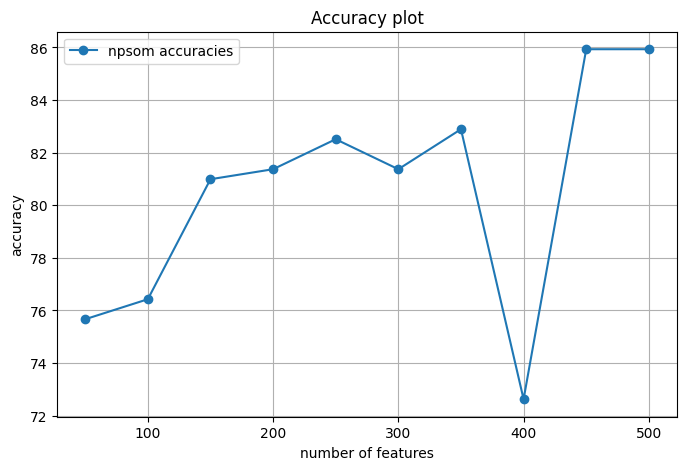

In [39]:
plt.figure(figsize=(8, 5))
plt.plot(numberoffeatures ,npsom_accuracies, label='npsom accuracies', marker='o')
# Labels and legend
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.title('Accuracy plot')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [15]:
npsom_accuracies

[76.04562640190125,
 77.56654024124146,
 81.74905180931091,
 81.74905180931091,
 83.26995968818665,
 82.50950574874878,
 85.9315574169159,
 87.07224130630493,
 85.5513334274292,
 71.48289084434509]